# Meridional Heat Transport

Using advective and parameterised heat transport diagnostics

Note I didn't deal with the tripole properly, so zonal averaging is over the x coordinate of the model.

Related issue: https://github.com/ACCESS-Community-Hub/access-om3-paper-1/issues/12

Using an ARE session with normalbw-XXLarge resources, and conda env xp65 analysis3-25.10

Code drawn heavily from [cosima recipes MHT example](https://github.com/julia-neme/cosima-recipes/blob/jn_meridional_heat_transport/03-Mains/Meridional_heat_transport.ipynb) and [ACCESS-OM2 MHT eval figure](https://github.com/COSIMA/ACCESS-OM2-1-025-010deg-report/tree/master/figures/meridional_heat_transport).



In [1]:
#parameters

### USER EDIT start
# esm_file='/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json'
esm_file='/g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json'
esm_file='/g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-5165c0f8/datastore.json'
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.dpi']= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-1/notebooks/"
os.makedirs(plotfolder, exist_ok=True)

# needed for mkmd START 
notebook_name='not_using_mkfigs.sh'
notebooks_dir = os.path.join(f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-1", "notebooks")
os.makedirs(notebooks_dir, exist_ok=True)
os.chdir(notebooks_dir)
print("Changed working directory to:", os.getcwd())
from mkfigs_configdoc import mkmd,get_notebook_name
notebook_name=get_notebook_name(notebook_name)
## example usage (note if the first argument to mkmd remains the same, you can insert multiple figures from the same notebook): 
#if notebook_name!='not_using_mkfigs.sh': plt.savefig(plotfolder+'mkmd/'+notebook_name[:-6]+'1.png', dpi=300, bbox_inches='tight')
#if notebook_name!='not_using_mkfigs.sh': mkmd("Template notebook","`"+notebook_name+"`: Example figure 1 of ACCESS-OM3 sea surface height (m).",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+'1.png',plotfolder+'mkmd/')
#if notebook_name!='not_using_mkfigs.sh': mkmd("Template notebook","`"+notebook_name+"`: Example figure 2 of ACCESS-OM3 sea surface height (m).",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+'2.png',plotfolder+'mkmd/')
# needed for mkmd STOP

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)


Changed working directory to: /g/data/tm70/cyb561/access-om3-paper-1/notebooks
Notebook name is: not_using_mkfigs.sh
ESM datastore path:  /g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-5165c0f8/datastore.json
Plot folder path:  /g/data/tm70/cyb561/access-om3-paper-1/notebooks/


In [2]:
import xarray as xr
import intake
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from distributed import Client
import cftime
import os
import matplotlib.pyplot as plt
import cmocean as cm
import numpy as np

/g/data/xp65/public/apps/med_conda/envs/analysis3-26.02/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml


In [3]:
client = Client(threads_per_worker=1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-26.02/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44783 instead
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-26.02/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-26.02/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysi

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44783/status,
Dashboard: /proxy/44783/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46547,Workers: 0
Dashboard: /proxy/44783/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39237,Total threads: 1
Dashboard: /proxy/40043/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:38307,


### Load ACCESS-OM3-25km MHT diagnostics 

In [3]:
exptname = os.path.basename(os.path.dirname(esm_file))

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)


In [4]:
#Load residual mean advective heat transport, vertically integrated
T_ady_2d = datastore.search(variable='T_ady_2d', frequency="1mon").to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1},
        decode_timedelta=True
    ))
#Load neutral diffusive heat transport, vertically integrated
T_diffy_2d = datastore.search(variable='T_diffy_2d', frequency="1mon").to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1},
        decode_timedelta=True
    ))
#Load horizontal boundary diffusive heat transport, vertically integrated (not present)
# T_hbd_diffy_2d = datastore.search(variable='T_hbd_diffy_2d', frequency="1mon").to_dask(
#     xarray_open_kwargs = dict(
#         chunks={"time": -1},
#         decode_timedelta=True
#     ))


/g/data/xp65/public/apps/med_conda/envs/analysis3-26.02/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-26.02/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [5]:
#get rid of bad y coord points 
T_ady_2d = T_ady_2d.isel(yq=slice(10, None))
T_diffy_2d= T_diffy_2d.isel(yq=slice(10, None))

Text(0, 0.5, 'Heat flux (W)')

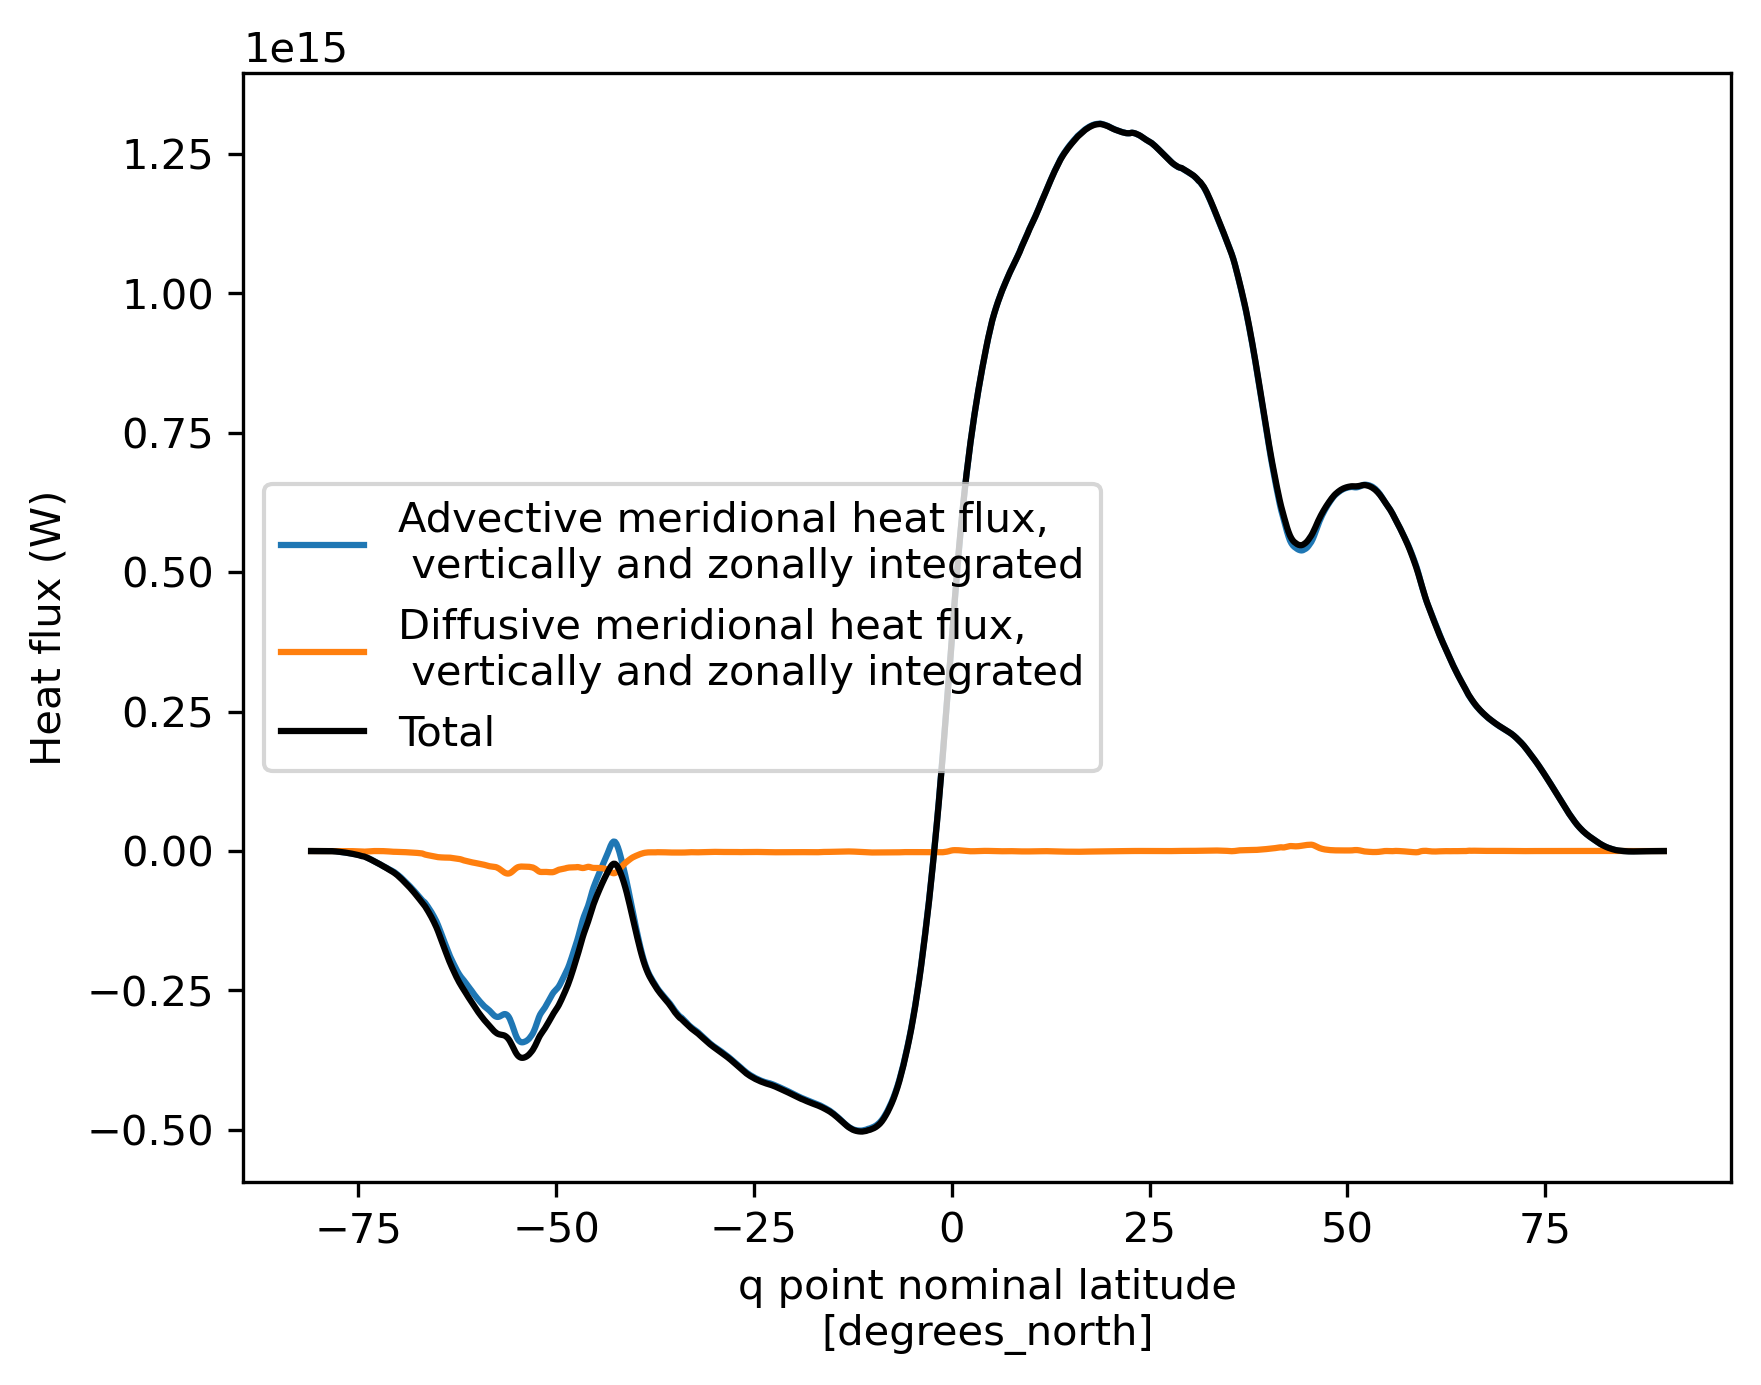

In [6]:
# quick and dirty plot
T_ady_2d.T_ady_2d.sum('xh').mean('time').plot(label = 'Advective meridional heat flux, \n vertically and zonally integrated')
T_diffy_2d.T_diffy_2d.sum('xh').mean('time').plot(label = 'Diffusive meridional heat flux, \n vertically and zonally integrated')
(T_diffy_2d.T_diffy_2d.sum('xh').mean('time')+T_ady_2d.T_ady_2d.sum('xh').mean('time')).plot(label = 'Total',color = 'k')

plt.legend()
plt.ylabel('Heat flux (W)')



### Load ACCESS-OM2-025 MHT diagnostic 

(advective heat flux `temp_yflux_adv_int_z` plus parameterised `temp_yflux_ndiffuse`, `temp_yflux_gm`, `temp_yflux_submeso`)

Using OMIP cycle 1, following COSIMA recipes example https://github.com/COSIMA/cosima-recipes/blob/main/03-Mains/Meridional_heat_transport.ipynb

Also help from https://github.com/COSIMA/ACCESS-OM2-1-025-010deg-report/blob/master/figures/meridional_heat_transport/Meridional_Heat_Transport.ipynb

In [7]:
catalog = intake.cat.access_nri
experiment = '025deg_jra55_iaf_omip2_cycle1'
cat_subset = catalog[experiment]
var_search = cat_subset.search(variable='temp_yflux_adv_int_z')
darray = var_search.to_dask(xarray_open_kwargs={
            "decode_timedelta": False,
            'chunks': "auto"
        })
temp_yflux_adv_int_z_cycle1 = darray['temp_yflux_adv_int_z']

var_search = cat_subset.search(variable='temp_yflux_gm_int_z')
darray = var_search.to_dask(xarray_open_kwargs={
            "decode_timedelta": False,
            'chunks': "auto"
        })
temp_yflux_gm_int_z_cycle1 = darray['temp_yflux_gm_int_z']

var_search = cat_subset.search(variable='temp_yflux_ndiffuse_int_z')
darray = var_search.to_dask(xarray_open_kwargs={
            "decode_timedelta": False,
            'chunks': "auto"
        })
temp_yflux_ndiffuse_int_z_cycle1 = darray['temp_yflux_ndiffuse_int_z']

var_search = cat_subset.search(variable='temp_yflux_submeso_int_z')
darray = var_search.to_dask(xarray_open_kwargs={
            "decode_timedelta": False,
            'chunks': "auto"
        })
temp_yflux_submeso_int_z_cycle1 = darray['temp_yflux_submeso_int_z']




Text(0, 0.5, 'Heat flux (W)')

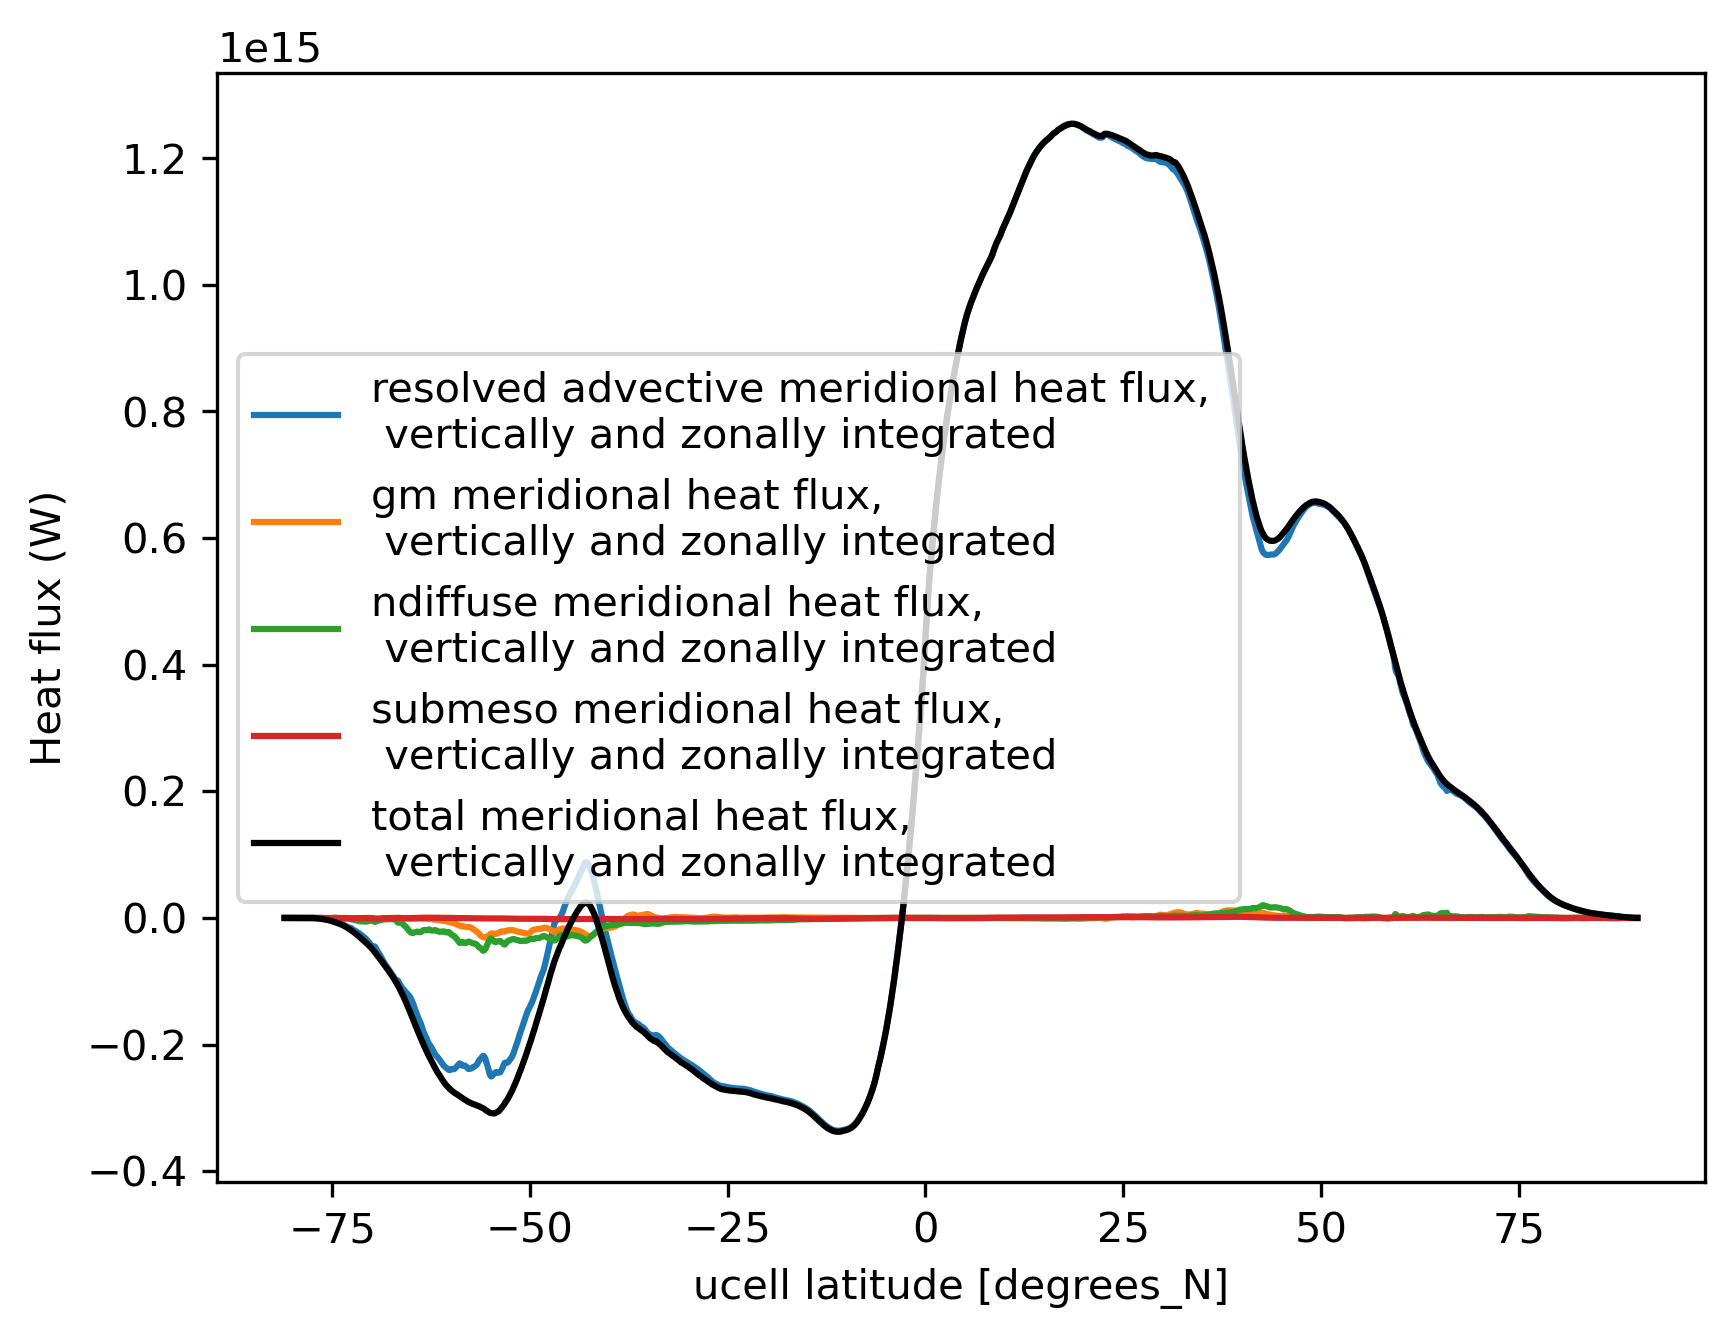

In [8]:
# quick and dirty plot
temp_yflux_adv_int_z_cycle1.sum('xt_ocean').mean('time').plot(label = 'resolved advective meridional heat flux, \n vertically and zonally integrated')
temp_yflux_gm_int_z_cycle1.sum('xt_ocean').mean('time').plot(label = 'gm meridional heat flux, \n vertically and zonally integrated')
temp_yflux_ndiffuse_int_z_cycle1.sum('xt_ocean').mean('time').plot(label = 'ndiffuse meridional heat flux, \n vertically and zonally integrated')
temp_yflux_submeso_int_z_cycle1.sum('xt_ocean').mean('time').plot(label = 'submeso meridional heat flux, \n vertically and zonally integrated')
(temp_yflux_adv_int_z_cycle1.sum('xt_ocean') \
                 + temp_yflux_gm_int_z_cycle1.sum('xt_ocean') \
                 + temp_yflux_ndiffuse_int_z_cycle1.sum('xt_ocean') \
                 + temp_yflux_submeso_int_z_cycle1.sum('xt_ocean') ).mean('time').plot(color = 'k', label = 'total meridional heat flux, \n vertically and zonally integrated')
plt.legend()
plt.ylabel('Heat flux (W)')

Ensure we are comparing same time periods (ACCESS-OM2 shorter)

In [9]:
temp_yflux_adv_int_z_cycle1.time

<xarray.DataArray 'time' (time: 732)> Size: 6kB
array(['1958-01-14T12:00:00.000000000', '1958-02-13T00:00:00.000000000',
       '1958-03-14T12:00:00.000000000', ..., '2018-10-14T12:00:00.000000000',
       '2018-11-14T00:00:00.000000000', '2018-12-14T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 6kB 1958-01-14T12:00:00 ... 2018-12-14T12:...
Attributes:
    long_name:       time
    cartesian_axis:  T
    calendar_type:   GREGORIAN
    bounds:          time_bounds

In [10]:
T_ady_2d.time

<xarray.DataArray 'time' (time: 684)> Size: 5kB
array(['1958-01-16T12:00:00.000000000', '1958-02-15T00:00:00.000000000',
       '1958-03-16T12:00:00.000000000', ..., '2014-10-16T12:00:00.000000000',
       '2014-11-16T00:00:00.000000000', '2014-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 5kB 1958-01-16T12:00:00 ... 2014-12-16T12:...
Attributes:
    long_name:      time
    axis:           T
    calendar_type:  GREGORIAN
    bounds:         time_bnds

Zonally integrate to get MHT (ignoring the fact that zonal average near the tripole will be a bit incorrect)

In [11]:
MHT_OM2_025 = temp_yflux_adv_int_z_cycle1.sum('xt_ocean') \
                 + temp_yflux_gm_int_z_cycle1.sum('xt_ocean') \
                 + temp_yflux_ndiffuse_int_z_cycle1.sum('xt_ocean') \
                 + temp_yflux_submeso_int_z_cycle1.sum('xt_ocean') 

In [19]:
#cb - 11/2 added this so that the next command will work with the latest run
tsteps=np.shape(T_ady_2d.time)[0]


In [20]:
#cb old way
#MHT_OM3_25k = T_ady_2d.isel(time = np.arange(732)).T_ady_2d.sum('xh') \
#                 + T_diffy_2d.isel(time = np.arange(732)).T_diffy_2d.sum('xh')
MHT_OM3_25k = T_ady_2d.isel(time = np.arange(tsteps)).T_ady_2d.sum('xh') \
                 + T_diffy_2d.isel(time = np.arange(tsteps)).T_diffy_2d.sum('xh')

In [22]:
MHT_OM2_025 = MHT_OM2_025.load()
MHT_OM3_25k = MHT_OM3_25k.load()

### Plot time mean

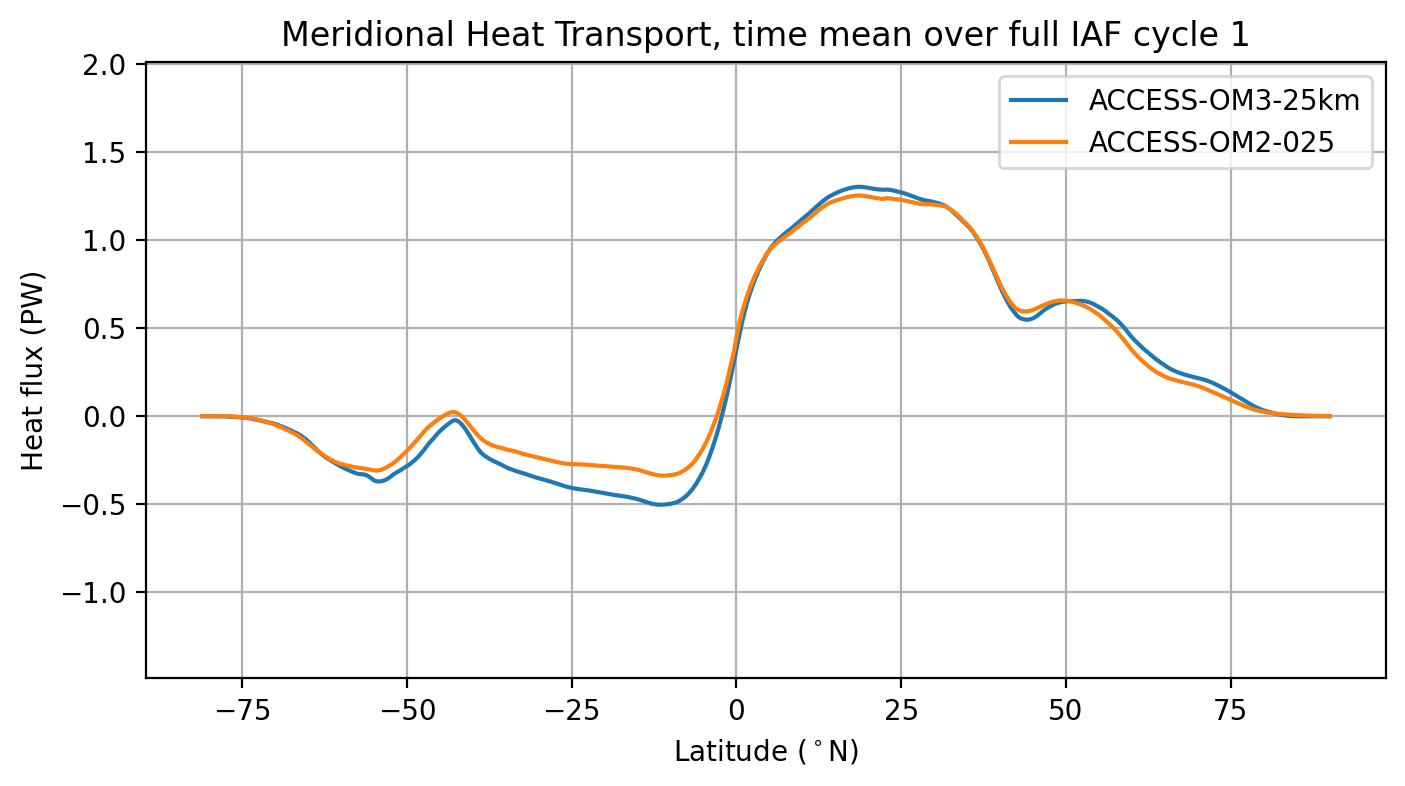

In [23]:
fig, axes = plt.subplots(dpi = 200, figsize = (8,4))

(MHT_OM3_25k.mean('time')/1e15).plot(x = 'yq',label = 'ACCESS-OM3-25km')
(MHT_OM2_025.mean('time')/1e15).plot(x = 'yu_ocean',label = 'ACCESS-OM2-025')

plt.legend()
plt.ylabel('Heat flux (PW)')
plt.title('Meridional Heat Transport, time mean over full IAF cycle 1')
plt.xlabel('Latitude ($^\circ$N)')
plt.ylim(-1.49,2.01)

plt.grid()

### Plot time mean + individual years

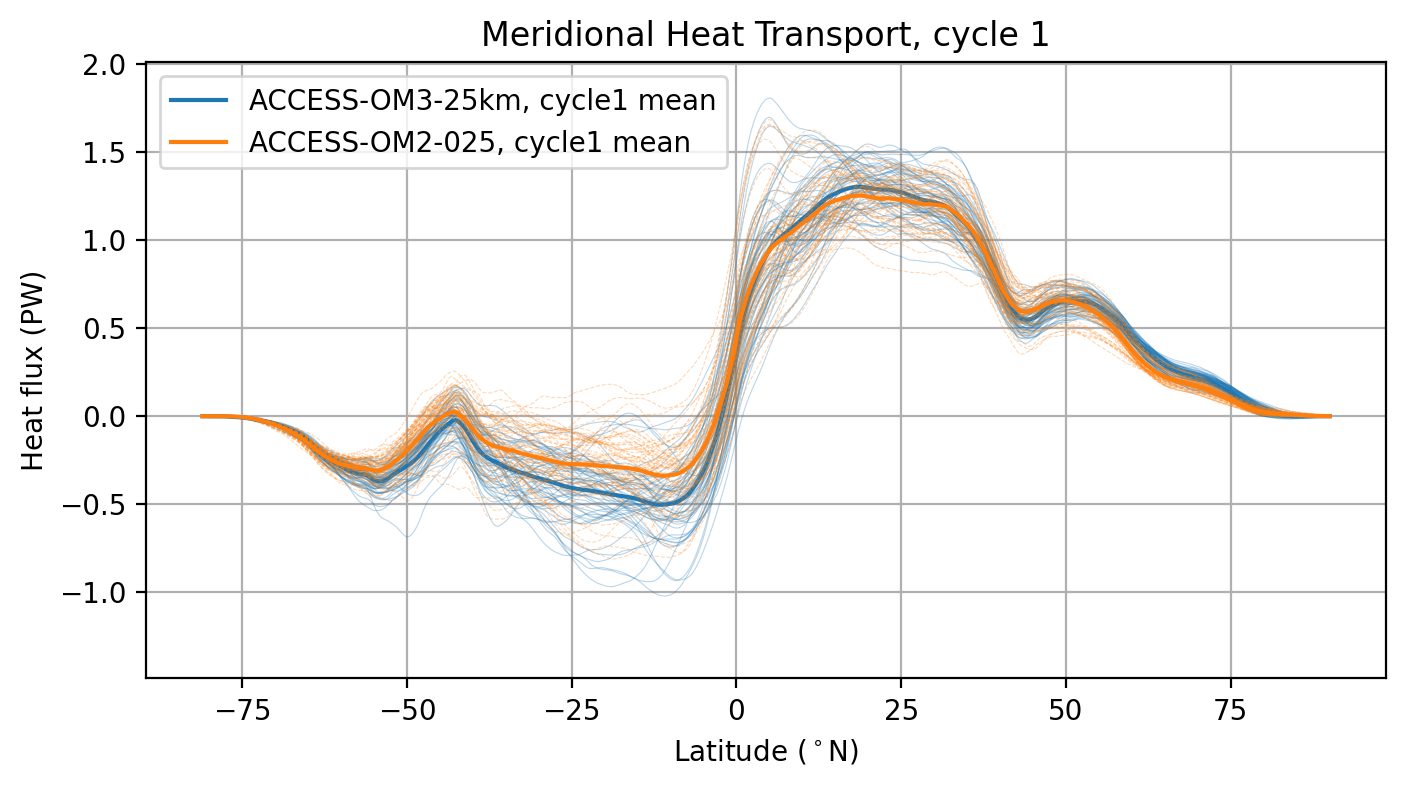

In [24]:
fig, axes = plt.subplots(dpi = 200, figsize = (8,4))

(MHT_OM3_25k.mean('time')/1e15).plot(x = 'yq',label = 'ACCESS-OM3-25km, cycle1 mean')
(MHT_OM3_25k.groupby('time.year').mean('time')/1e15).plot.line(x = 'yq',color = 'C0',
                                                                         alpha = 0.3, lw = 0.4,
                                                                         add_legend = False)
(MHT_OM2_025.mean('time')/1e15).plot(x = 'yu_ocean',label = 'ACCESS-OM2-025, cycle1 mean')
(MHT_OM2_025.groupby('time.year').mean('time')/1e15).plot.line(x = 'yu_ocean',color = 'C1',
                                                                         alpha = 0.3, lw = 0.4,ls = '--',
                                                                         add_legend = False)
plt.legend()
plt.ylabel('Heat flux (PW)')
plt.title('Meridional Heat Transport, cycle 1')
plt.xlabel('Latitude ($^\circ$N)')
plt.ylim(-1.49,2.01)
plt.grid()

### Add more models/cycles
All 6 025deg OMIP cycles + 01 deg

Check they all have length 732 (monthly diagnostics over full cycle)

In [ ]:
def find_MHT_OM2(expt,gm = True, ndiffuse = True, submeso = True):
    catalog = intake.cat.access_nri
    experiment = expt
    cat_subset = catalog[experiment]
    
    var_search = cat_subset.search(variable='temp_yflux_adv_int_z')
    darray = var_search.to_dask(xarray_open_kwargs={
                "decode_timedelta": False,
                'chunks': "auto"
            })
    temp_yflux_adv_int_z_cycle1 = darray['temp_yflux_adv_int_z']
    if gm:
        try:
            var_search = cat_subset.search(variable='temp_yflux_gm_int_z')
            temp_yflux_gm_int_z_cycle1 = var_search.to_dask(xarray_open_kwargs={
                        "decode_timedelta": False,
                        'chunks': "auto"
                    }).temp_yflux_gm_int_z
            
        except ValueError:
            print('no temp_yflux_gm_int_z in ',expt)
            gm = False
    if ndiffuse:
        try:
            var_search = cat_subset.search(variable='temp_yflux_ndiffuse_int_z')
            temp_yflux_ndiffuse_int_z_cycle1 = var_search.to_dask(xarray_open_kwargs={
                        "decode_timedelta": False,
                        'chunks': "auto"
                    }).temp_yflux_ndiffuse_int_z
        except ValueError:
            print('no temp_yflux_ndiffuse_int_z in ',expt)
            ndiffuse = False
    if submeso:
        try:
            var_search = cat_subset.search(variable='temp_yflux_submeso_int_z')
            temp_yflux_submeso_int_z_cycle1 = var_search.to_dask(xarray_open_kwargs={
                        "decode_timedelta": False,
                        'chunks': "auto"
                    }).temp_yflux_submeso_int_z
        except ValueError:
            print('no temp_yflux_submeso_int_z in ',expt)
            submeso = False

        
    MHT_OM2_025 = temp_yflux_adv_int_z_cycle1.sum('xt_ocean') 
    if gm:
        MHT_OM2_025 += temp_yflux_gm_int_z_cycle1.sum('xt_ocean')
    if ndiffuse:
        MHT_OM2_025 += temp_yflux_ndiffuse_int_z_cycle1.sum('xt_ocean')
    if submeso:
        MHT_OM2_025 += temp_yflux_submeso_int_z_cycle1.sum('xt_ocean')
    return MHT_OM2_025


experiment = '025deg_jra55_iaf_omip2_cycle2'
MHT_OM2_025_cycle2 = find_MHT_OM2(experiment)
MHT_OM2_025_cycle2 = MHT_OM2_025_cycle2.load()
print(experiment, len(darray.time))

experiment = '025deg_jra55_iaf_omip2_cycle3'
MHT_OM2_025_cycle3 = find_MHT_OM2(experiment)
MHT_OM2_025_cycle3 = MHT_OM2_025_cycle3.load()
print(experiment, len(darray.time))

experiment = '025deg_jra55_iaf_omip2_cycle4'
MHT_OM2_025_cycle4 = find_MHT_OM2(experiment)
MHT_OM2_025_cycle4 = MHT_OM2_025_cycle4.load()
print(experiment, len(darray.time))

experiment = '025deg_jra55_iaf_omip2_cycle5'
MHT_OM2_025_cycle5 = find_MHT_OM2(experiment)
MHT_OM2_025_cycle5 = MHT_OM2_025_cycle5.load()
print(experiment, len(darray.time))

experiment = '025deg_jra55_iaf_omip2_cycle6'
MHT_OM2_025_cycle6 = find_MHT_OM2(experiment)
MHT_OM2_025_cycle6 = MHT_OM2_025_cycle6.load()
print(experiment, len(darray.time))

experiment = '01deg_jra55v140_iaf_cycle3'
MHT_OM2_01 = find_MHT_OM2(experiment, gm = False, ndiffuse = False)
MHT_OM2_01 = MHT_OM2_01.load()
print(experiment, len(darray.time))


025deg_jra55_iaf_omip2_cycle2 732


In [ ]:
fig, axes = plt.subplots(dpi = 200, figsize = (8,4))

(MHT_OM3_25k.mean('time')/1e15).plot(x = 'yq',label = 'ACCESS-OM3-25km, cycle1')
(MHT_OM2_025.mean('time')/1e15).plot(x = 'yu_ocean',label = 'ACCESS-OM2-025, cycle1')
(MHT_OM2_025_cycle2.mean('time')/1e15).plot(x = 'yu_ocean',label = 'ACCESS-OM2-025, cycles2',lw = 0.5)
(MHT_OM2_025_cycle3.mean('time')/1e15).plot(x = 'yu_ocean',label = 'ACCESS-OM2-025, cycle3',lw = 0.5)
(MHT_OM2_025_cycle4.mean('time')/1e15).plot(x = 'yu_ocean',label = 'ACCESS-OM2-025, cycle4',lw = 0.5)
(MHT_OM2_025_cycle5.mean('time')/1e15).plot(x = 'yu_ocean',label = 'ACCESS-OM2-025, cycle5',lw = 0.5)
(MHT_OM2_025_cycle6.mean('time')/1e15).plot(x = 'yu_ocean',label = 'ACCESS-OM2-025, cycle6',lw = 0.5)
(MHT_OM2_01.mean('time')/1e15).plot(x = 'yu_ocean',label = 'ACCESS-OM2-01, cycle3',color = 'k', ls = '--')

plt.legend(loc = 'upper left', bbox_to_anchor = (1.02,1))
plt.ylabel('Heat flux (PW)')
plt.title('Meridional Heat Transport, time mean over full IAF cycle')
plt.xlabel('Latitude ($^\circ$N)')
plt.ylim(-1.49,2.01)

plt.grid()

### Compare to observations (ERBE, NCEP, ECMWF) using COSIMA recipes example

Copy COSIMA recipes example: https://github.com/COSIMA/cosima-recipes/blob/main/03-Mains/Meridional_heat_transport.ipynb

Currently missing a file: https://github.com/COSIMA/cosima-recipes/issues/638

So I copied file from Ryan: https://github.com/COSIMA/ACCESS-OM2-1-025-010deg-report/blob/master/figures/meridional_heat_transport/ANNUAL_TRANSPORTS_1985_1989.ascii.txt

In [ ]:
#Path to the file containing observations
filename = '/g/data3/ik11/from_hh5_tmp/cosima/observations/original/MHT/obs_vq_am_estimates.txt'

#Creating empty variables to store our observations
erbe_mht = []
erbe_lat = []

#Opening data and saving it to empty variables above
with open(filename) as f:
    #Open each line from rows 1 to 96
    for line in f.readlines()[1:96]:
        #Separating each line to extract data
        line = line.strip()
        sline = line.split()
        #Extracting latitude and MHT and saving to empty variables
        erbe_lat.append(float(sline[0]))
        erbe_mht.append(float(sline[3]))

#Checking MHT variables
erbe_mht

In [ ]:
#Path to the file containing observations
filename = '/g/data/x77/cy8964/access-om3-eval/ANNUAL_TRANSPORTS_1985_1989.ascii'

#Creating empty variables to store our observations
ncep_g_mht = []
ecwmf_g_mht = []
ncep_g_err = []
ecwmf_g_err = []
ncep_a_mht = []
ecwmf_a_mht = []
ncep_a_err = []
ecwmf_a_err = []
ncep_p_mht = []
ecwmf_p_mht = []
ncep_p_err = []
ecwmf_p_err = []
ncep_i_mht = []
ecwmf_i_mht = []
ncep_i_err = []
ecwmf_i_err = []
ncep_ip_mht = []
ecwmf_ip_mht = []
ncep_ip_err = []
ecwmf_ip_err = []
o_lat = []
#Opening data and saving it to empty variables above
with open(filename) as f:
#Open each line in file (ignoring the first row)
    for line in f.readlines()[1:]:
        #Separating each line to extract data
        line = line.strip()
        sline = line.split()
        #Extracting values and saving to correct variable defined above
        o_lat.append(float(sline[0]) * 0.01)         # T42 latitudes (north to south)
        ncep_g_mht.append(float(sline[4]) * 0.01)    # Residual Ocean Transport - NCEP
        ecwmf_g_mht.append(float(sline[5]) * 0.01)   # Residual Ocean Transport - ECWMF
        ncep_a_mht.append(float(sline[7]) * 0.01)    # Atlantic Ocean Basin Transport - NCEP
        ncep_p_mht.append(float(sline[8]) * 0.01)    # Pacific Ocean Basin Transport - NCEP
        ncep_i_mht.append(float(sline[9]) * 0.01)    # Indian Ocean Basin Transport - NCEP
        ncep_g_err.append(float(sline[10]) * 0.01)   # Error Bars for NCEP Total Transports
        ncep_a_err.append(float(sline[11]) * 0.01)   # Error Bars for NCEP Atlantic Transports 
        ncep_p_err.append(float(sline[12]) * 0.01)   # Error Bars for NCEP Pacific Transports 
        ncep_i_err.append(float(sline[13]) * 0.01)   # Error Bars for NCEP Indian Transports 
        ecwmf_a_mht.append(float(sline[15]) * 0.01)  # Atlantic Ocean Basin Transport - ECWMF
        ecwmf_p_mht.append(float(sline[16]) * 0.01)  # Pacific Ocean Basin Transport - ECWMF
        ecwmf_i_mht.append(float(sline[17]) * 0.01)  # Indian Ocean Basin Transport - ECWMF
        ecwmf_g_err.append(float(sline[18]) * 0.01)  # Error Bars for ECWMF Total Transports
        ecwmf_a_err.append(float(sline[19]) * 0.01)  # Error Bars for NCEP Atlantic Transports
        ecwmf_p_err.append(float(sline[20]) * 0.01)  # Error Bars for NCEP Pacific Transports
        ecwmf_i_err.append(float(sline[21]) * 0.01)  # Error Bars for NCEP Indian Transports

#Calculating MHT
ncep_ip_mht  = [a+b for a, b in zip(ncep_p_mht,ncep_i_mht)]
ecwmf_ip_mht = [a+b for a, b in zip(ecwmf_p_mht,ecwmf_i_mht)]
ncep_ip_err  = [max(a, b) for a, b in zip(ncep_p_err, ncep_i_err)]
ecwmf_ip_err = [max(a, b) for a, b in zip(ecwmf_p_err, ecwmf_i_err)]

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)

#Plotting MHT from model outputs
(MHT_OM3_25k.mean('time')/1e15).plot(x = 'yq',label = 'ACCESS-OM3-25km cycle 1')
(MHT_OM2_025.mean('time')/1e15).plot(x = 'yu_ocean',label = 'ACCESS-OM2-025 cycle 1')
(MHT_OM2_01.mean('time')/1e15).plot(x = 'yu_ocean',label = 'ACCESS-OM2-01 cycle 3')


#Adding observations and error bars for observations
ax.plot(erbe_lat, erbe_mht, 'k--', linewidth=1, label="ERBE, JRA-25, NCEP/NCAR, and ERA40")
plt.errorbar(o_lat[::-1], ncep_g_mht[::-1], yerr=ncep_g_err[::-1], c='gray', fmt='s', 
             markerfacecolor='k', markersize=3, capsize=2, linewidth=1, label="NCEP")
plt.errorbar(o_lat[::-1], ecwmf_g_mht[::-1], yerr=ecwmf_g_err[::-1], c='gray', fmt='D', 
             markerfacecolor='white', markersize=3, capsize=2, linewidth=1, label="ECWMF")

plt.errorbar( 24,  1.5,  yerr=0.3,  fmt='o', c='black', markersize=3, capsize=2, linewidth=1,
             label="Macdonald and Wunsch 1996")
plt.errorbar(-30, -0.9,  yerr=0.3,  fmt='o', c='black', markersize=3, capsize=2, linewidth=1)
plt.errorbar( 24,  2.0,  yerr=0.3,  fmt='x', c='green', markersize=3, capsize=2, linewidth=1,
             label="Lavin et al. and Bryden et al.")
plt.errorbar( 24,  1.83, yerr=0.28, fmt='^', c='red',   markersize=4, capsize=2, linewidth=1,
             label="Ganachaud and Wunsch 2003")
plt.errorbar(-30, -0.6,  yerr=0.3,  fmt='^', c='red',   markersize=4, capsize=2, linewidth=1)
plt.errorbar(-19, -0.8,  yerr=0.3,  fmt='^', c='red',   markersize=4, capsize=2, linewidth=1)
plt.errorbar( 47,  0.6,  yerr=0.1,  fmt='^', c='red',   markersize=4, capsize=2, linewidth=1)

# add legend
plt.legend(frameon=False, fontsize=12)
plt.axhline(y=0, linewidth=1, color='black')

# limits along the y axis
plt.ylim(-2.25, 2.75)

# add titles and labels
plt.title('Global Ocean Meridional Heat Transport', fontsize=18)
plt.xlabel('Latitude ($^\circ$N)')
plt.ylabel('PW');

if notebook_name!='not_using_mkfigs.sh': plt.savefig(plotfolder+'mkmd/'+notebook_name[:-6]+'1.png', dpi=300, bbox_inches='tight')
if notebook_name!='not_using_mkfigs.sh': mkmd("Meridional Heat Transport","`"+notebook_name+"`: Global ocean meridional heat transport.",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+'1.png',plotfolder+'mkmd/')


In [20]:
client.close()